In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL
from sklearn import metrics
from xgboost import XGBClassifier
from source.utils import MetricsSaver, saveConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

sys.path.append('/home/texs/Documentos/Repositories/ts2vec')
from ts2vec import TS2Vec

/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datasetName = 'PAMAP2' # PAMAP2 or HAR-UML20
FEATURE_SIZE = 32
# CLASS_LABELS = ['Sedentary', 'Light', 'Moderate', 'Vigorous']
UMAP_NEIGHTBORS = 20
N_EPOCHS = 2000
RESULTS_PATH = 'results'
TS2VEC = True

In [3]:


if datasetName == 'PAMAP2':
    dataset = DatasetPAMAP2(mode = 'leave-one-subject', signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handGyro1', 'handGyro2', 'handGyro3'])
    
elif datasetName ==  'HAR-UML20':
    dataset = DatasetHARUML20(mode = 'leave-one-subject')
    
CLASS_LABELS = dataset.activities

saver = MetricsSaver(datasetName + '_HAR_TS2VEC', rows = ['train', 'test'], cols=['F1-score', 'Balanced Accuracy', 'Accuracy'])

In [4]:
predicted_classes = []
real_classes = []
while dataset.loadData():
    if datasetName == 'PAMAP2':
        le = LabelEncoder()
        dataset.y_train = le.fit_transform(dataset.y_train)
        dataset.y_test = le.transform(dataset.y_test)
    
    # Preparing data
    ts_train = TSerie(dataset.X_train[:, :, :6], dataset.y_train)
    ts_test = TSerie(dataset.X_test[:, :, :6], dataset.y_test)
    ts_train.center()
    ts_test.center()
    # ts_train.folding_features_v2()
    # ts_test.folding_features_v2()
    
    model = TS2Vec(
        input_dims=6,
        device=0,
        output_dims=64,
        batch_size=64,
    )
    # Xi = np.expand_dims(X[:, :, i], axis=2)
    
    model.fit(ts_train.X, verbose=True,n_epochs = 8)
    ts_train.features =  model.encode(ts_train.X, encoding_window='full_series')
    ts_test.features =  model.encode(ts_test.X, encoding_window='full_series')
    
    # Getting features
    # model = UMAP_FL(n_components=FEATURE_SIZE,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS)
    # ts_train.features = model.fit_transform(ts_train.features, y=ts_train.y)
    # ts_test.features = model.transform(ts_test.features)
    
    
    # Classifying
    clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
    clf.fit(ts_train.features, ts_train.y)
    train_pr = clf.predict(ts_train.features)
    test_pr = clf.predict(ts_test.features)
    predicted_classes.append(test_pr)
    real_classes.append(ts_test.y)


    # Save metrics
    train_f1 = metrics.f1_score(ts_train.y, train_pr, average='weighted')
    test_f1 = metrics.f1_score(ts_test.y, test_pr, average='weighted')
    train_bacc = metrics.balanced_accuracy_score(ts_train.y, train_pr)
    test_bacc = metrics.balanced_accuracy_score(ts_test.y, test_pr)
    train_acc = metrics.accuracy_score(ts_train.y, train_pr)
    test_acc = metrics.accuracy_score(ts_test.y, test_pr)
    
    saver.addLog('train', 'F1-score', train_f1)
    saver.addLog('test', 'F1-score', test_f1)
    saver.addLog('train', 'Balanced Accuracy', train_bacc)
    saver.addLog('test', 'Balanced Accuracy', test_bacc)
    saver.addLog('train', 'Accuracy', train_acc)
    saver.addLog('test', 'Accuracy', test_acc)
    
predicted_classes = np.concatenate(predicted_classes, axis = 0)
real_classes = np.concatenate(real_classes, axis = 0)

Epoch #0: loss=8.81050785879294
Epoch #1: loss=3.609829530119896
Epoch #2: loss=3.1236774201194444
Epoch #3: loss=2.820464032391707
Epoch #4: loss=2.644895277917385
Epoch #5: loss=2.330321782579025
Epoch #6: loss=1.9807204095025857
Epoch #7: loss=1.8457349091768265
Epoch #0: loss=6.82745865520678
Epoch #1: loss=3.4170822770972
Epoch #2: loss=2.995375008332102
Epoch #3: loss=2.6370886626996493
Epoch #4: loss=2.280742793334158
Epoch #5: loss=1.988404789723848
Epoch #6: loss=1.761870352845443
Epoch #7: loss=1.6036154383107235
Epoch #0: loss=6.107585607742776
Epoch #1: loss=3.271149379866464
Epoch #2: loss=2.7895978080983066
Epoch #3: loss=2.4421092855687045
Epoch #4: loss=2.1168941891923243
Epoch #5: loss=1.8621276629214385
Epoch #6: loss=1.6002380397855018
Epoch #7: loss=1.517928946991356


/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch #0: loss=5.697631465891997
Epoch #1: loss=3.176897885898749
Epoch #2: loss=2.7237765888373056
Epoch #3: loss=2.3467676105598607
Epoch #4: loss=2.031384518990914
Epoch #5: loss=1.7682887303332488
Epoch #6: loss=1.6146246405939262
Epoch #7: loss=1.492045817275842
Epoch #0: loss=6.181490372585994
Epoch #1: loss=3.4032126934297624
Epoch #2: loss=2.8611981099651707
Epoch #3: loss=2.512597748028335
Epoch #4: loss=2.128337744743593
Epoch #5: loss=1.9325379325497536
Epoch #6: loss=1.6791298786799114
Epoch #7: loss=1.5773960108398108
Epoch #0: loss=5.450962477541984
Epoch #1: loss=3.207958459854126
Epoch #2: loss=2.695116547828025
Epoch #3: loss=2.3194966252813947
Epoch #4: loss=1.9715772613565972
Epoch #5: loss=1.7836806609275493
Epoch #6: loss=1.5462261920279645
Epoch #7: loss=1.4008620419400803


/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch #0: loss=5.560926608035439
Epoch #1: loss=3.1458997073926422
Epoch #2: loss=2.659124103345369
Epoch #3: loss=2.293316429539731
Epoch #4: loss=2.041668327231156
Epoch #5: loss=1.8133983963414242
Epoch #6: loss=1.5804954817420558
Epoch #7: loss=1.4787725159996434
Epoch #0: loss=7.557122230529785
Epoch #1: loss=3.506410320599874
Epoch #2: loss=2.901028037071228
Epoch #3: loss=2.5866220171252885
Epoch #4: loss=2.2589042286078134
Epoch #5: loss=1.9211000005404155
Epoch #6: loss=1.7106669197479885
Epoch #7: loss=1.7360786572098732
Epoch #0: loss=6.764706638124254
Epoch #1: loss=3.397326385533368
Epoch #2: loss=2.887700122815591
Epoch #3: loss=2.4836575940803245
Epoch #4: loss=2.1357675316157163
Epoch #5: loss=1.8531509317733623
Epoch #6: loss=1.7597205473317041
Epoch #7: loss=1.4639173172138356


/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [5]:
if datasetName == 'PAMAP2':
    classes = np.unique(real_classes)
    CLASS_LABELS = [dataset.activities_map[classL] for classL in le.inverse_transform(classes) ]

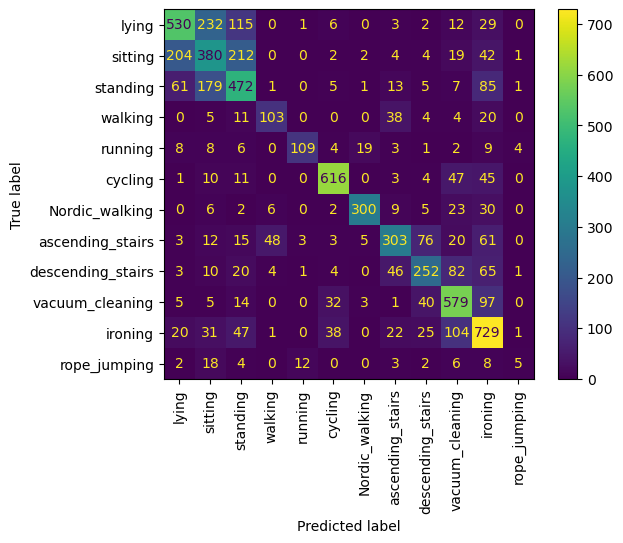

In [6]:

saveConfusionMatrix(real_classes, predicted_classes, datasetName + '_HAR_TS2VEC', labels=CLASS_LABELS, xrotation=90)

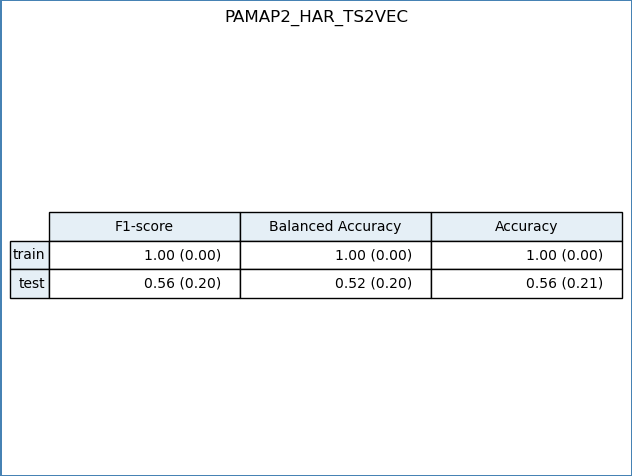

In [7]:
saver.toImage()